<a href="https://colab.research.google.com/github/mwithgod3952/Conquering-Kaggle-s-challenge/blob/main/Marketing_Analytics_Cohort_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size = 4>Data preparation</font>

In [ ]:
# font
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [1]:
# Basic environment
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'
    ITALIC = '\x1B'

# drive
from google.colab import drive; drive.mount('/content/drive', force_remount=True)

# path
import os

org_pth = '/content/drive/MyDrive'
_new_pth = [x for x in os.listdir(org_pth) if x.startswith('Cohort')][0]
new_pth = f'{org_pth}/{_new_pth}' 

if new_pth.startswith('/content') and new_pth.endswith('practice'):
    os.chdir(new_pth)
    wp = os.getcwd()
    print(f'\t\n {new_pth}')

Mounted at /content/drive
	
 /content/drive/MyDrive/Cohort_Analysis_practice


In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files; files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jhleekr","key":"740259ff05a1aa87d388c6ecd1153f10"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d carrie1/ecommerce-data
!kaggle datasets download -d mustafacicek/online-retail-final

print('\n')

!unzip ecommerce-data
!unzip online-retail-final

  0% 0.00/7.20M [00:00<?, ?B/s]
100% 7.20M/7.20M [00:00<00:00, 121MB/s]
  0% 0.00/6.30M [00:00<?, ?B/s]
100% 6.30M/6.30M [00:00<00:00, 154MB/s]


Archive:  ecommerce-data.zip
  inflating: data.csv                
Archive:  online-retail-final.zip
  inflating: online_retail_final.csv  


In [2]:
dataset = [x for x in os.listdir(wp) if x.endswith('.csv')]
print(dataset)

['data.csv', 'online_retail_final.csv']


<font size = 4>Library</font>

In [3]:
# analyzation
import re
import ast
import random
import numpy as np
import pandas as pd
from numpy import asarray
from multiprocessing import Pool
from sklearn.preprocessing import MinMaxScaler

# visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.rc('font', family='NanumBarunGothic') 
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from google.colab import data_table

# options
pd.options.mode.chained_assignment = None

In [4]:
import multiprocessing as mp; print('\n\t - number of CPUs available', mp.cpu_count())


	 - number of CPUs available 8


In [5]:
df1 = pd.read_csv(f'{wp}/{dataset[0]}', encoding= 'unicode_escape')
df1.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [6]:
print(f'\t\n {color.BOLD}Shape : {df1.shape}{color.END} \n')

print(f'{color.BOLD}- NULL{color.END}')
print(df1.isnull().sum())
print('\n')

	
 Shape : (541909, 8) 

- NULL
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64




In [7]:
df1[df1.Description.isnull()].iloc[:2, :]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,12/1/2010 14:32,0.0,NaN,United Kingdom


In [8]:
des_nullDf = df1[df1.Description.isnull()].reset_index( drop=True )

In [9]:
if len(des_nullDf) == des_nullDf.CustomerID.isnull().sum():
    print('T')
else:
    print('F')

T


In [10]:
des_nullDf.UnitPrice.value_counts()

0.0    1454
Name: UnitPrice, dtype: int64

<font size = 2>상위의 과정을 통해 "Description" 열에 포함된 내용이 없을 때 "CustomerID" 정보 역시 누락되어 있음을 확인하였습니다, 더불어, "UnitPrice"는 0임을 확하였습니다.</font>

In [11]:
des_notnullDf = df1[df1.Description.notnull()].reset_index( drop=True )
ID_NULL_cnt = des_notnullDf.CustomerID.isnull().sum()
print(f'\n\t {color.BOLD}- "Description"정보가 확인되나, ID 정보가 누락된 경우의 수 : {ID_NULL_cnt}{color.END}')


	 - "Description"정보가 확인되나, ID 정보가 누락된 경우의 수 : 133626


In [12]:
print(f'\n\t - {color.BOLD}"StockCode"정보는 정수로만 이루어져 있거나 정수와 함께 문자열이 결합되어 기록된 것이 일반적이고, 이 외 주식코드 검색을 목적으로 문자열로만 이루어진 것들이 아래와 같이 존재합니다.{color.END}\n')
for i in df1[df1['StockCode'].apply(lambda x: str('Y') if re.search('[0-9]+', x) else str('N')) == 'N'].StockCode.unique():
    print(f'\t\t {i}')


	 - "StockCode"정보는 정수로만 이루어져 있거나 정수와 함께 문자열이 결합되어 기록된 것이 일반적이고, 이 외 주식코드 검색을 목적으로 문자열로만 이루어진 것들이 아래와 같이 존재합니다.

		 POST
		 D
		 DOT
		 M
		 BANK CHARGES
		 S
		 AMAZONFEE
		 m
		 DCGSSBOY
		 DCGSSGIRL
		 PADS
		 B
		 CRUK


In [13]:
df1 = df1[df1.Description.notnull() & df1.CustomerID.notnull()]
df1.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [14]:
df1.loc[df1['InvoiceNo'].apply(lambda x: str('Y') if re.search('[a-zA-Z]+', x) else str('N')) == 'Y', 'InvoiceNo'].apply(lambda x: str(x)[0]).unique()

array(['C'], dtype=object)

In [15]:
wC  = df1[df1['InvoiceNo'].apply(lambda x: x.startswith('C'))]
nwC = df1[df1['InvoiceNo'].apply(lambda x: True if len(set('AC') & set(x)) == 0 else False)]
if (len(wC) == sum(wC.Quantity < 0)) and (len(nwC) == sum(nwC.Quantity >= 0)):
    print('T')
else:
    print('N')    

T


<font size = 2>'InvoiceNO'정보 값 중 특정 값에 알파벳 값이 결합된 경우를 발견하여 확인해본 결과, 일반 정수값 번호 외에 'C'와 'A'가 결합된 경우를 확인하였습니다.</font>

<font size = 2>그 중, 'C'로 구분한 Quantity값이 모두 음수 인 것을 확인하였고 더불어, Quantity값이 음수이나 'InvoiceNO'값이 잘못 구분된 케이스 역시 없음으로, 취소된 주문건을 구분하기 위한 구분자임을 확신할 수 있습니다.</font>


<font size = 2>우선 'Cancelled'라는 열을 만들어 주문취소가 포함된 행을 1로 나머지 행을 0으로 구분합니다.</font>


In [16]:
df1.loc[wC.index, 'Cancelled'] = int(1); df1.loc[df1.Cancelled.isnull(), 'Cancelled'] = int(0)

<font size = 2>아래부터는 주문건에 대한 정보만을을 취합하여 분석을 진행하겠습니다.</font>

In [17]:
_df1 = df1[df1.Cancelled == 0]
_df1.Cancelled.value_counts()

0.0    397924
Name: Cancelled, dtype: int64

In [18]:
col_relevance = []
contain_alpha = _df1[_df1['StockCode'].str.contains("^[a-zA-Z]")]
stc_str = contain_alpha.iloc[:, 1].value_counts().index.tolist()
for i in range(len(stc_str)):
    y = set(list(map(lambda x: str(x), _df1[_df1['StockCode'] == stc_str[i]].loc[:, ['StockCode', 'Description']].values.tolist())))
    col_relevance.append(ast.literal_eval(list(y)[0]))

cr_df = pd.DataFrame( columns=list(_df1.columns)[1:] )   
for i in range(2):
    cr_df.iloc[:, i] = list(zip(*col_relevance))[i]
for j in range(len(stc_str)):
    cr_df.iloc[j, 2:] = random.sample(_df1[_df1.StockCode == stc_str[j]].iloc[:, 3:].values.tolist(), 1)[0] 

print(f'{color.BOLD}- number of values ​​containing the alphabet{color.END}')
print(contain_alpha.StockCode.value_counts())
print(f'{color.BLUE}-{color.END}'*3)
print(f'{color.BOLD}- comparison table comparing the values ​​of the Stockcode and other columns{color.END}')
cr_df    

- number of values ​​containing the alphabet
POST            1099
M                290
C2               133
DOT               16
BANK CHARGES      12
PADS               4
Name: StockCode, dtype: int64
---
- comparison table comparing the values ​​of the Stockcode and other columns


,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled
0,POST,POSTAGE,1,2/2/2011 14:51,40.0,12414.0,Austria,0.0
1,M,Manual,6,4/13/2011 15:49,0.39,16348.0,United Kingdom,0.0
2,C2,CARRIAGE,1,4/27/2011 10:02,50.0,14911.0,EIRE,0.0
3,DOT,DOTCOM POSTAGE,1,10/31/2011 14:09,901.58,14096.0,United Kingdom,0.0
4,BANK CHARGES,Bank Charges,1,11/28/2011 12:51,15.0,14704.0,United Kingdom,0.0
5,PADS,PADS TO MATCH ALL CUSHIONS,1,7/26/2011 10:13,0.001,15618.0,United Kingdom,0.0


<font size = 2></font>

In [19]:
_df1 = _df1[~ _df1['StockCode'].str.contains("^[a-zA-Z]")]

In [20]:
_df1.loc[:, 'Description'] = list(_df1.Description.str.lower())

In [21]:
def Vis_rank_and_cnt(colN='CustomerID', topicN='고객', rt=0.01, clr='Reds_r'):

    Y = _df1[colN].value_counts().sort_values(ascending=False).head(round((len(_df1) / 100)*rt))

    fig, ax = plt.subplots( figsize=(6, 9) )
    sns.barplot(y=Y.index, x=Y.values, orient='h', ax=ax, order=Y.index, palette=clr)

    plt.ylabel(colN)
    plt.xlabel('Transection Count')
    plt.title(f'{topicN} ID 기준 재방문 수치 및 상위 {rt}% 순위표')
    
    return plt.show()    

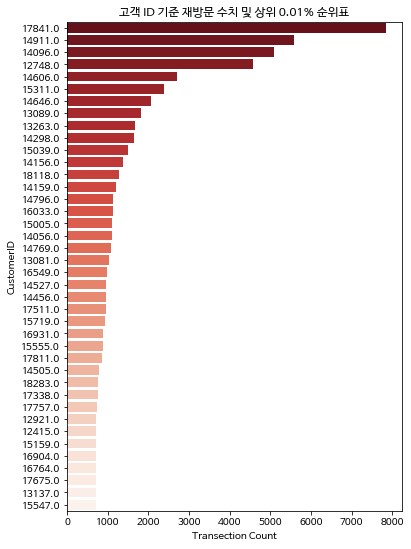

In [22]:
Vis_rank_and_cnt(colN='CustomerID', topicN='고객')

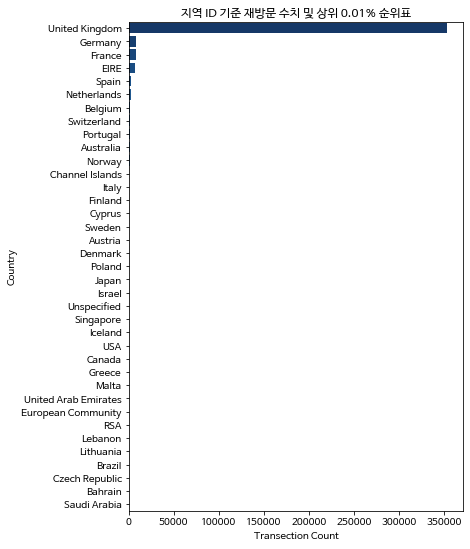

In [23]:
Vis_rank_and_cnt(colN='Country', topicN='지역', rt=0.01, clr='Blues_r')

<font size = 2>위의 분석을 통해 고객 및 지역 기준 재방문 수를 확인할 수 있습니다.</font>

<font size = 2>고객의 경우 약 4000번을 기준으로 상위그룹이 구분됨을 알수 있습니다. 지역의 경우 영국이 독보적으로 높다는 것을 알 수 있습니다.</font>




In [24]:
price_nunq = _df1.groupby('StockCode').UnitPrice.nunique()
price_nunq[price_nunq != 1].describe()

count    2624.000000
mean        2.815549
std         1.079163
min         2.000000
25%         2.000000
50%         3.000000
75%         3.000000
max        12.000000
Name: UnitPrice, dtype: float64

In [25]:
over3_codes = list(set(price_nunq[price_nunq >= 3].index))
indexes = list(map(lambda x: np.where(_df1.reset_index(drop=True).StockCode == x)[0].tolist(), over3_codes))
m_indexes = sum(indexes, [])
over3_df = _df1.reset_index(drop=True).iloc[sorted(m_indexes)].reset_index(drop=True)
over3_df.loc[:, 'InvoiceDate'] = over3_df.InvoiceDate.apply(lambda x: pd.to_datetime(x))
over3_dfFv = over3_df.loc[:, ['InvoiceDate', 'StockCode',	'Quantity',	'UnitPrice']].copy()
over3_dfFv.head(2)

,InvoiceDate,StockCode,Quantity,UnitPrice
0,2010-12-01 08:26:00,85123A,6,2.55
1,2010-12-01 08:26:00,71053,6,3.39


<font size = 2>단가 표준편차의 평균 이상의 "StockCode"만을 추가로 선별하겠습니다.</font>

In [26]:
price_var = over3_dfFv.groupby(['StockCode'])['UnitPrice'].apply(lambda x: np.var(x))
avg_over  = list(price_var[price_var > price_var.describe()['mean']].index)
_indexes  = list(map(lambda x: np.where(over3_dfFv.StockCode == x)[0].tolist(), avg_over)); _indexes = sum(_indexes, [])
over_3_varavg_dfFv = over3_dfFv.iloc[_indexes, :].reset_index(drop=True).copy()

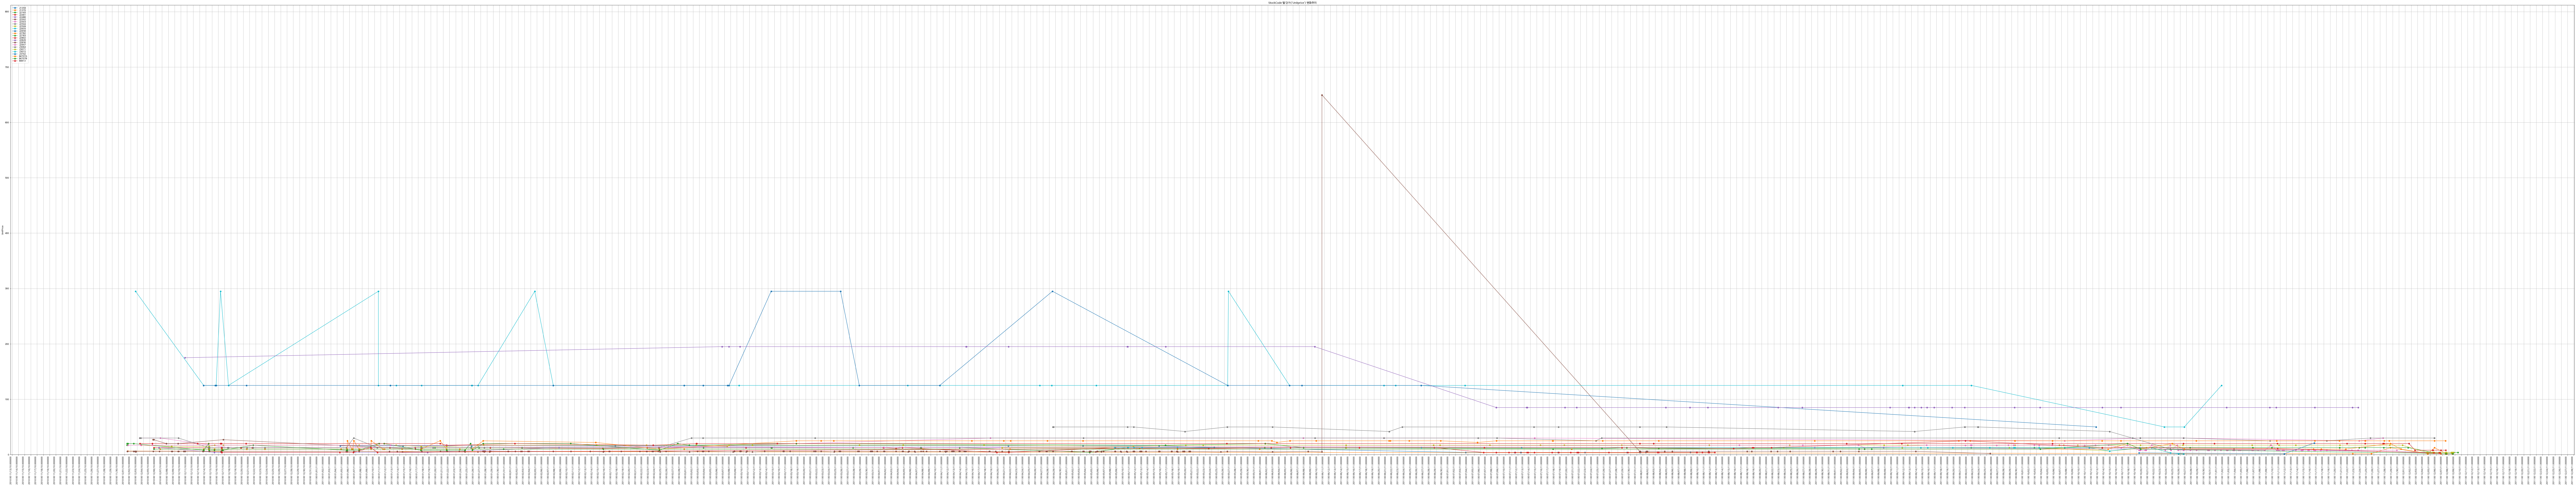

In [28]:
xtick_interval = mdates.DayLocator(interval=1)
xtick_format   = mdates.DateFormatter('%Y %M %D.%f')
fig, ax = plt.subplots( figsize=(200, 40) )  

for key, group in over_3_varavg_dfFv.groupby(['StockCode']):
    ax = group.plot(ax=ax, kind='line', x='InvoiceDate', y='UnitPrice', label=key, marker='o')
ax.xaxis.set_major_locator(xtick_interval)
ax.xaxis.set_major_formatter(xtick_format)
ax.autoscale_view()
ax.legend(loc='upper left')

_ = plt.xticks(rotation=90, )
_ = plt.grid()
_ = plt.xlabel('')
_ = plt.ylim(0, over3_dfFv['UnitPrice'].max() * 1.25)
_ = plt.ylabel('UnitPrice')
_ = plt.title("StockCode 별 단가('Unitprice') 변화추이")
_ = plt.rcParams.update({'legend.labelspacing': 0.0001})
_ = plt.show()

In [ ]:
unq_timestamps = over_3_varavg_dfFv[['InvoiceDate']].sort_values('InvoiceDate').drop_duplicates(keep=False).iloc[:, 0].tolist()
unq_timestamps[: 1]

[Timestamp('2010-12-01 09:45:00')]

In [ ]:
# import plotly.graph_objects as go
# fig = go.Figure(
#     data=[go.Bar(y=[2, 1, 3])],
#     layout_title_text="A Figure Displayed with the 'colab' Renderer"
# )
# fig.show(renderer="colab")


Vol_pattern = Vol_pattern.reset_index()
cols = Vol_pattern.columns.tolist()[1:12]

fig = px.line(Vol_pattern, x="date", y=cols,
             color_discrete_map={cols[10]: 'rgba(191, 191, 191, 0.9)'})

fig.update_layout(
    barmode='group', 
    hovermode='x',
    width=1200,
    height=400,
    plot_bgcolor='lightcyan',
    title_text="Figuring out a similarity of patterns between varying differences of VIX(Volatility Index) and each volume.")

iplot(fig)

In [43]:
!pip install kora -q
!pip install -U kaleido
import kora.install.orca

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
import plotly.io as pio

In [46]:
import plotly.graph_objects as go
fig = go.Figure(
    data=[go.Bar(y=[2, 1, 3])],
    layout_title_text="A Figure Displayed with the 'colab' Renderer"
)
fig.show(renderer="colab")


In [45]:
fig = px.scatter_3d(over_3_varavg_dfFv, x=over_3_varavg_dfFv.iloc[:, 0], y=over_3_varavg_dfFv.iloc[:, 3], z=over_3_varavg_dfFv.iloc[:, 2])

fig.show(renderer="svg")

ValueError: ignored

In [38]:
over_3_varavg_dfFv

,InvoiceDate,StockCode,Quantity,UnitPrice
0,2011-01-04 12:51:00,21359,1,15.95
1,2011-01-14 13:28:00,21359,1,15.95
2,2011-01-25 12:03:00,21359,1,15.95
3,2011-01-25 13:38:00,21359,1,15.95
4,2011-01-25 13:38:00,21359,1,15.95
...,...,...,...,...
978,2011-11-10 14:28:00,84813,16,10.95
979,2011-12-05 14:03:00,84813,3,2.95
980,2011-12-06 10:58:00,84813,2,2.95
981,2011-12-06 12:26:00,84813,8,2.95


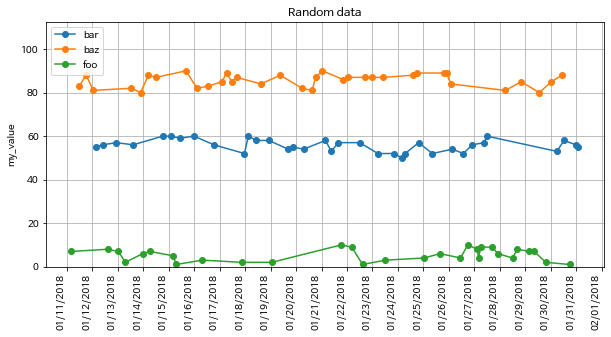

In [ ]:
df = generate_random_data()

plot_gb_time_series(df, 'my_timestamp', 'my_series', 'my_value',
                    figsize=(10, 5), title="Random data")


In [ ]:
df

,my_timestamp,my_series,my_value
0,2018-01-11 03:59:50,foo,7
1,2018-01-11 11:32:05,baz,83
2,2018-01-11 18:02:20,baz,88
3,2018-01-12 00:53:21,baz,81
4,2018-01-12 03:31:15,bar,55
...,...,...,...
95,2018-01-30 10:30:08,baz,88
96,2018-01-30 12:31:29,bar,58
97,2018-01-30 17:47:25,foo,1
98,2018-01-30 23:49:45,bar,56


	 - minimum value: 0.0, median value: 1.95, maximum value: 649.5
	 - The number of cases where a unit price is zero: 33




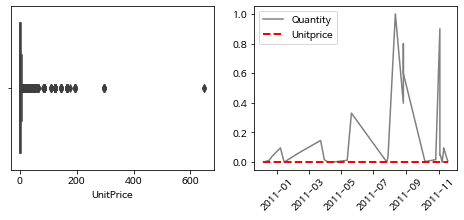

In [ ]:
print(f"\t {color.BOLD}- minimum value: {_df1.UnitPrice.describe()['min']}, median value: {np.median(_df1.UnitPrice)}, maximum value: {_df1.UnitPrice.describe()['max']}{color.END}")

fig, axes = plt.subplots(1, 2, figsize=(8, 3) )
sns.boxplot(x=_df1.UnitPrice, ax=axes[0])

up_e0 = _df1[_df1['UnitPrice'] == 0].reset_index(drop=True).iloc[:-1]
up_e0['InvoiceDate'] = up_e0.InvoiceDate.apply(lambda x: pd.to_datetime(x))
up_e0 = up_e0.sort_values(by='InvoiceDate')

print(f"\t - The number of cases where a unit price is zero: {sum(_df1['UnitPrice'] == 0)}")
print('\n')

color = ["grey", "red", '#edae49', '#66a182']
scaler = MinMaxScaler()
scaled = scaler.fit_transform(up_e0.iloc[:, [3, 5]].values.tolist())

axes[1].plot(up_e0.InvoiceDate, scaled[:, 0], color=color[0], label='Quantity')
axes[1].plot(up_e0.InvoiceDate, scaled[:, 1], color=color[1], linestyle='--', linewidth=2, label='Unitprice')
axes[1].legend(loc='upper left')
axes[1].tick_params(axis='x', rotation=45)

plt.show()

<font size = 2></font>